In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import image
import os

## Training 

In [2]:
#loading 240 images for training & 160 for testing

train_image_list=[]
test_image_list=[]
for i in range(1,41):
    j=1
    s = os.listdir('s'+str(i)+'/')
    for image in s:
        if(j<=6):
            im = Image.open('s'+str(i)+'/' + image)
            train_image_list.append(np.asarray(im).flatten())
        else:
            im = Image.open('s'+str(i)+'/' + image)
            test_image_list.append(np.asarray(im).flatten())
        j+=1

In [3]:
print(len(train_image_list))
print(len(test_image_list))

240
160


In [4]:
# 1. Generating the face dataset for training (60%)

Face_Db = np.array(train_image_list).T
print(Face_Db.shape)

# 2. Mean Calculation

mn,p = Face_Db.shape
M = np.zeros((mn,1))
for i in range(mn):
        for j in range(p):
            M[i] += Face_Db[i][j]
        M[i] /= p
print(M.shape)

# 3. Do mean Zero

delt = np.zeros((mn,p))
for i in range(mn):
    for j in range(p):
        delt[i][j]=Face_Db[i][j]-M[i]

    
# 4. Covariance of delt (mean aligned faces)

def cov(delt):
    row,col=delt.shape
    covm = np.zeros((col,col))        
    for z in range(col):
        for y in range(col):
            covm[z][y] = (1/row) * np.dot(delt[:,y].T,delt[:,z])                   
    return covm

cov_matrix = cov(delt)

# 5. eigenvalue and eigenvector decomposition (sorted)

eigenValues, eigenVectors = np.linalg.eig(cov_matrix)
idx = eigenValues.argsort()[::-1]   
eigen_val = eigenValues[idx]
eigen_vector = eigenVectors[:,idx]
eigen_val = np.diag(eigen_val)
print("...Eigen Values...")
print(eigen_val.shape)
print()
print("...Eigen Vector...")
print(eigen_vector.shape)
print()

# 6. Finding the best direction (Generation of feature vectors)

k=100
Feature_vector = eigen_vector[:,0:k]
print(Feature_vector.shape)

# 7. Generating Eigenfaces

Eigen_faces = np.dot(Feature_vector.T,delt.T)
print(Eigen_faces.shape)

# 8. Generating Signature of Each Face

Signature = np.dot(Eigen_faces,delt)
print(Signature.shape)

#print(Feature_vector)

(10304, 240)
(10304, 1)
...Eigen Values...
(240, 240)

...Eigen Vector...
(240, 240)

(240, 100)
(100, 10304)
(100, 240)


In [5]:
P=len(train_image_list)
n=6 #no. of images per person
number_of_classes=P//n
print(number_of_classes)

40


In [6]:
def meann(Face):
    mn,p = Face.shape
    M = np.zeros((mn,1))
    for i in range(mn):
        for j in range(p):
            M[i] += Face[i][j]
        M[i] /= p
    return M

def sub(X,M):
    res = X
    n,c = X.shape
    
    for i in range(n):
        for j in range(c):
            res[i][j] = res[i][j] - M[i]
    
    return res

In [7]:
# 3.

mean_each_class = np.zeros((k,number_of_classes))

for i in range(number_of_classes):
    pf=Signature[:,6*i:6*i+6]
    mean_each_class[:,i] = meann(pf).T
    
mean_pf = meann(Signature)
mean_each_class.shape
#print(mean_pf)

In [8]:
# 4. within class scatter matrix (SW)

SW = np.zeros((k,k))
for i in range(number_of_classes):
    pf=Signature[:,6*i:6*i+6]
    Var = sub(pf,mean_each_class[:,i])
    SW += (np.dot(Var,Var.T))
    #print(6*i," " ,6*i+6)
print(SW.shape)
#print(SW)

(100, 100)


In [9]:
# Between Class Scatter Matrix
SB = np.zeros((k,k))
for i in range(number_of_classes):
    M_i = np.reshape(mean_each_class[:,i],(1,mean_each_class[:,i].size)).T
    SB += (np.dot(sub(M_i,mean_PF),M_i.T))

SB.shape
#print(SB)

(100, 100)

In [10]:
# 5. criterion function 

J=np.dot(np.linalg.inv(SW),SB)
print(J.shape)
#print(J)

(100, 100)


In [11]:
# 6. Eigen vector and Eigen values of the Criterion function

J_eigenValues, J_eigenVectors = np.linalg.eig(J)
idx = J_eigenValues.argsort()[::-1]   
J_eigenValues = J_eigenValues[idx]
J_ev = J_eigenVectors[:,idx]

J_ev.shape

(100, 100)

In [12]:
# 7. Best principal components

m = 100

In [13]:
# 8. Construct feature (W) vectors of using these k bests

W = J_ev[:,0:m]
W.shape

(100, 100)

In [14]:
# 9. Generate the fisher faces (FF)

FF = np.dot(W.T,Signature)

## Testing

In [15]:
# 1. Read a test image

test_img=np.array(test_image_list).T
test_img.shape

(10304, 160)

In [16]:
# 2. Mean zero of the test 

Mean_img = np.zeros((test_img.shape))
for i in range(test_img.shape[1]):
    Mean_img[:,i] = np.subtract(test_img[:,i],np.mean(test_img[:,i]))
Mean_img.shape

(10304, 160)

In [17]:
# 3. Calculate the projected Eigen Face (PEF)

PEF = np.dot(Eigen_faces,Mean_img)
PEF.shape
#print(PEF)

(100, 160)

In [18]:
# 4. final projection (Projected Fisher Test Image)

Projected_Fisher_Test_Img = np.dot(W.T,PEF)
Projected_Fisher_Test_Img.shape
#print(Projected_Fisher_Test_Img)

(100, 160)

In [19]:
# 5. Euclidean distance between each column of the Fisher Faces to the Projected_Fisher_Test_img

def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist

def accuracy_fun(true_cl,pred_cl):
    count = 0
    for i in range(len(true_cl)):
        if(true_cl[i] == pred_cl[i]):
            count += 1
    accuracy_val = (count/len(true_cl))*100
    return accuracy_val

In [20]:
# column wise minimum distance calculation

import sys

true_Labels = np.arange(0,160)
true_Labels = (true_Labels//4)
accuracy_curve = []

for m in range(1,101):

    min_dist = sys.maxsize
    distances = [0] * test_img.shape[1]
    classes = [0] * test_img.shape[1]

    for i in range (Projected_Fisher_Test_Img.shape[1]):
        for j in range (FF.shape[1]):
            
            dist = euclidean_dist(Projected_Fisher_Test_Img[0:m,i],FF[0:m,j])
            
            if(dist < min_dist):
                min_dist = dist
                label = j

        distances[i] = min_dist
        classes[i] = (label//6)
        min_dist = sys.maxsize

    accuracy = accuracy_fun(true_Labels,classes)
    accuracy_curve.append(accuracy)
    


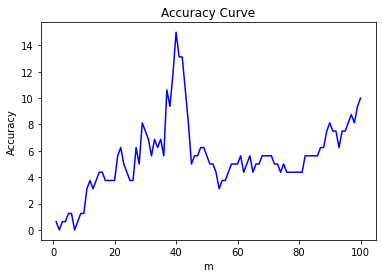

In [21]:
plt.plot(np.arange(1,101), accuracy_curve, color ="blue")  
plt.title("Accuracy Curve")  
plt.xlabel("m")  
plt.ylabel("Accuracy") 
plt.show()